In [306]:
import numpy as np
import random
import os

In [307]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [308]:
def norm_x(x):
    for col in range(x.shape[1]):
        vals = x[:,col]
        vals = (vals-np.mean(vals))/np.std(vals)
        x[:,col] = vals
    return x

In [309]:
def sampleChania(Chania, n_points):
    data = Chania[:,0:8]
    np.random.seed(0)
    order = np.argsort(np.random.random(data.shape[0]))
    x = data[order][:n_points, 1:5]   
    trueusers = data[order][:n_points,0]
    n_clusters = 5
    x = norm_x(x)
    return tf.constant(x, dtype=tf.float32), tf.constant(trueusers, dtype=tf.float32)

In [310]:
def plot_rssi(x, y, sess):
    xarray = x.eval(session=sess)
    yarray = y.eval(session=sess)
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    ax[0].scatter(xarray[:,3], xarray[:,2], c=xarray[:,1])
    ax[0].set_title("True Received Signal Strengths, min=%.4f, max=%.4f"%(np.min(xarray[:,1]), np.max(xarray[:,1])))
    
    ax[1].scatter(yarray[:,3], yarray[:,2], c=yarray[:,1])
    ax[1].set_title("Obfuscated Received Signal Strengths, min=%.4f, max=%.4f"%(np.min(yarray[:,1]), np.max(yarray[:,1])))

In [311]:
def plot_users(x, y, z, trueusers, sess):
    xarray = x.eval(session=sess)
    yarray = y.eval(session=sess)
    zarray = z.eval(session=sess)
    u = trueusers.eval(session=sess)
    
    fig, ax1 = plt.subplots(1, 2, figsize=(15,5))
    
    ax1[0].scatter(xarray[:,3], xarray[:,2], c=u)
    ax1[0].set_title("User Labels")
    
    ax1[1].scatter(yarray[:,3], yarray[:,2], c=u)
    ax1[1].set_title("Obfuscated data - User Labels")
    
    fig, ax2 = plt.subplots(1, 2, figsize=(15,5))
    
    ax2[0].scatter(xarray[:,3], xarray[:,2], c=np.argmax(zarray, axis=1))
    ax2[0].set_title("User Labels estimated by adversary")
    
    ax2[1].scatter(yarray[:,3], yarray[:,2], c=np.argmax(zarray, axis=1))
    ax2[1].set_title("Obfuscated data - User Labels estimated by adversary")

In [312]:
def plot_maps(sess):   
    testpoints = np.mgrid[-2:2:15j, -2:2:15j].reshape(2,-1).T
    grid = tf.constant(testpoints, dtype=tf.float32)

    inputmap = i8(i7(i6(i5(i4(i3(i2(i1(grid)))))))).eval(session=sess)
    outputmap = o8(o7(o6(o5(o4(o3(o2(o1(grid)))))))).eval(session=sess)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].scatter(testpoints[:,1], testpoints[:,0], c=inputmap[:,0])
    ax[0].set_title("Map created from True Data, min=%.4f, max=%.4f"%(np.min(inputmap[:,0]), np.max(inputmap[:,0])))
    ax[1].scatter(testpoints[:,1], testpoints[:,0], c=outputmap[:,0])
    ax[1].set_title("Map created from Obfuscated Data, min=%.4f, max=%.4f"%(np.min(outputmap[:,0]), np.max(outputmap[:,0])))

In [313]:
Chania = np.genfromtxt('processedChania.csv', delimiter=',')

In [338]:
Chania = Chania[np.where(Chania[:,2]<99)]

In [339]:
sess = tf.Session()
keras.backend.set_session(sess)

In [340]:
x, trueusers = sampleChania(Chania, 200)

In [341]:
p1 = keras.layers.Dense(4, activation=tf.nn.relu)
p2 = keras.layers.Dense(4, activation=tf.nn.relu)
p3 = keras.layers.Dense(4, activation=tf.nn.relu)
p4 = keras.layers.Dense(4, activation=tf.nn.relu)
p5 = keras.layers.Dense(4)

y = p5(p4(p3(p2(p1(x)))))
p_vars = [p1.variables, p2.variables, p3.variables, p4.variables, p5.variables]

In [342]:
i1 = keras.layers.Dense(16, input_shape=(2, ), activation=tf.nn.relu)
i2 = keras.layers.Dense(16, activation=tf.nn.relu)
i3 = keras.layers.Dense(16, activation=tf.nn.relu)
i4 = keras.layers.Dense(16, activation=tf.nn.relu)
i5 = keras.layers.Dense(16, activation=tf.nn.relu)
i6 = keras.layers.Dense(16, activation=tf.nn.relu)
i7 = keras.layers.Dense(16, activation=tf.nn.relu)
i8 = keras.layers.Dense(1)

m1 = i8(i7(i6(i5(i4(i3(i2(i1(x[:,2:]))))))))
m1_target = x[:,1]
m1_train = tf.train.GradientDescentOptimizer(0.01)
m1_vars = [i1.variables, i2.variables, i3.variables, i4.variables, 
           i5.variables, i6.variables, i7.variables, i8.variables]

In [343]:
o1 = keras.layers.Dense(16, input_shape=(2, ), activation=tf.nn.relu)
o2 = keras.layers.Dense(16, activation=tf.nn.relu)
o3 = keras.layers.Dense(16, activation=tf.nn.relu)
o4 = keras.layers.Dense(16, activation=tf.nn.relu)
o5 = keras.layers.Dense(16, activation=tf.nn.relu)
o6 = keras.layers.Dense(16, activation=tf.nn.relu)
o7 = keras.layers.Dense(16, activation=tf.nn.relu)
o8 = keras.layers.Dense(1)

m2 = o8(o7(o6(o5(o4(o3(o2(o1(y[:,2:]))))))))
m2_target = y[:,1]
m2_train = tf.train.GradientDescentOptimizer(0.01)
m2_vars = [o1.variables, o2.variables, o3.variables, o4.variables, 
           o5.variables, o6.variables, o7.variables, o8.variables]

In [344]:
a1 = keras.layers.Dense(4, activation=tf.nn.relu)
a2 = keras.layers.Dense(4, activation=tf.nn.relu)
a3 = keras.layers.Dense(4, activation=tf.nn.relu)
a4 = keras.layers.Dense(4, activation=tf.nn.relu)
a5 = keras.layers.Dense(5, activation=tf.nn.softmax)

users = a5(a4(a3(a2(a1(y)))))
a_train = tf.train.GradientDescentOptimizer(0.01)
a_vars = [a1.variables, a2.variables, a3.variables, a4.variables, a5.variables]

In [345]:
combined = a5(a4(a3(a2(a1(p5(p4(p3(p2(p1(x))))))))))
p_train = tf.train.GradientDescentOptimizer(0.01)

In [346]:
m1_loss = tf.placeholder(tf.float32)
m2_loss = tf.placeholder(tf.float32)
map_error = tf.placeholder(tf.float32)
adversary_loss = tf.placeholder(tf.float32)
privatizer_loss = tf.placeholder(tf.float32)
penalty = tf.placeholder(tf.float32)

In [347]:
sess.run(tf.global_variables_initializer())

In [348]:
# train m1
m1_loss = tf.reduce_mean(tf.squared_difference(m1, m1_target))
m1_train = m1_train.minimize(m1_loss, var_list = m1_vars)

In [349]:
# train m2
m2_loss = tf.reduce_mean(tf.squared_difference(m2, m2_target))
m2_train = m2_train.minimize(m2_loss, var_list = m2_vars)

In [350]:
adversary_loss = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, users))
# tf.math.reduce_max?
a_train = a_train.minimize(adversary_loss, var_list = a_vars)

In [351]:
map_error = tf.reduce_mean(tf.squared_difference(
    i8(i7(i6(i5(i4(i3(i2(i1(p5(p4(p3(p2(p1(x)))))[:,2:])))))))), 
    o8(o7(o6(o5(o4(o3(o2(o1(p5(p4(p3(p2(p1(x)))))[:,2:]))))))))
))

In [352]:
penalty = tf.constant(10, dtype=tf.float32)

In [353]:
privatizer_loss = tf.subtract(tf.multiply(map_error, penalty), 
                              tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, combined)))
p_train = p_train.minimize(privatizer_loss, var_list = p_vars)

0 a: 1.3532441 p: -1.3514698
1 a: 1.3533053 p: -1.3515979
2 a: 1.3532202 p: -1.3513306
3 a: 1.3533217 p: -1.3516825
4 a: 1.3533261 p: -1.3521212
5 a: 1.3532584 p: -1.3525414
6 a: 1.3533678 p: -1.3528866
7 a: 1.3533485 p: -1.3525766
8 a: 1.3533304 p: -1.3526462
9 a: 1.3532809 p: -1.3524766


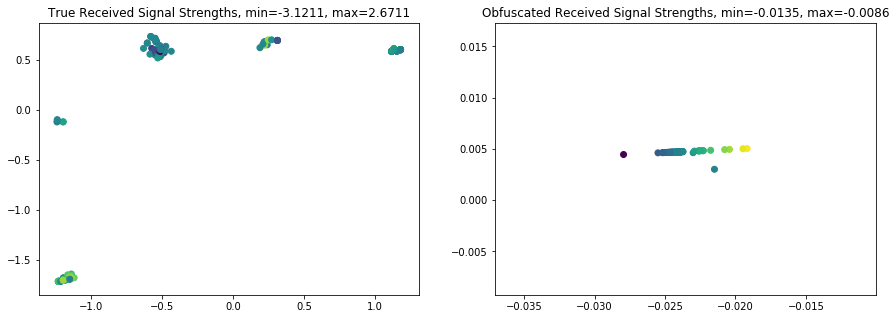

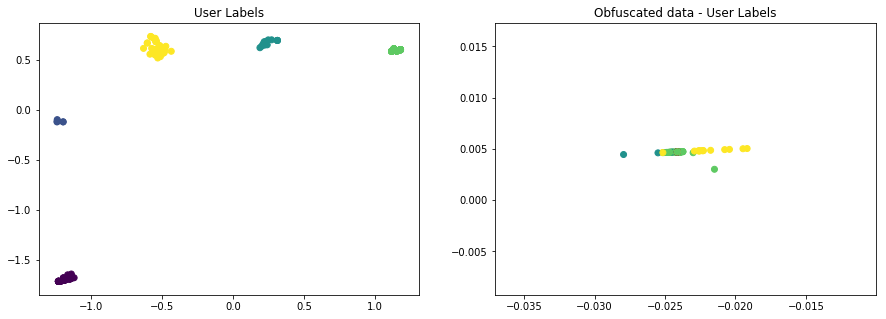

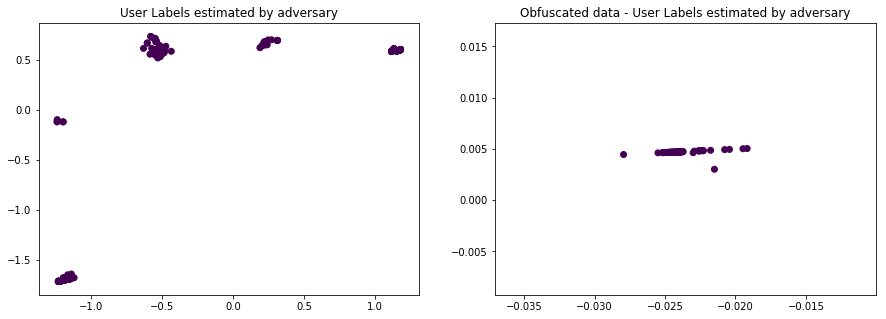

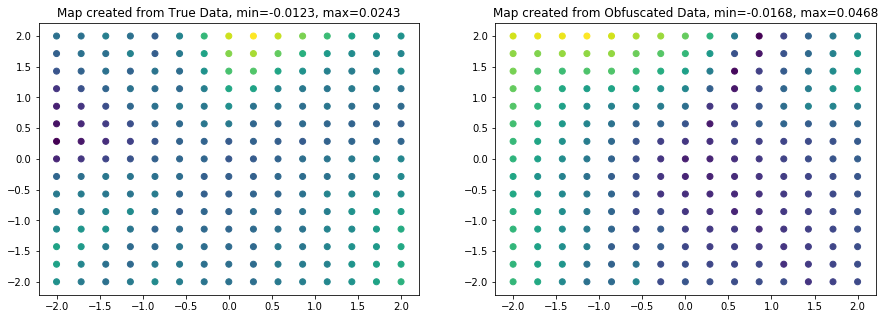

In [357]:
for i in range(10):
    x, trueusers = sampleChania(Chania, 200)
    y = p5(p4(p3(p2(p1(x)))))
    m1 = i8(i7(i6(i5(i4(i3(i2(i1(x[:,2:]))))))))
    m2 = o8(o7(o6(o5(o4(o3(o2(o1(y[:,2:]))))))))
    users = a5(a4(a3(a2(a1(y)))))
    combined = a5(a4(a3(a2(a1(p5(p4(p3(p2(p1(x))))))))))
    for j in range(25):
        for k in range(100):
            m1_train.run(session=sess)
            m2_train.run(session=sess)
            a_train.run(session=sess)
        p_train.run(session=sess)
    print(i, "a:", adversary_loss.eval(session=sess), "p:", privatizer_loss.eval(session=sess))
plot_rssi(x, y, sess)
plot_users(x, y, users, trueusers, sess)
plot_maps(sess)